# PASO A PASO

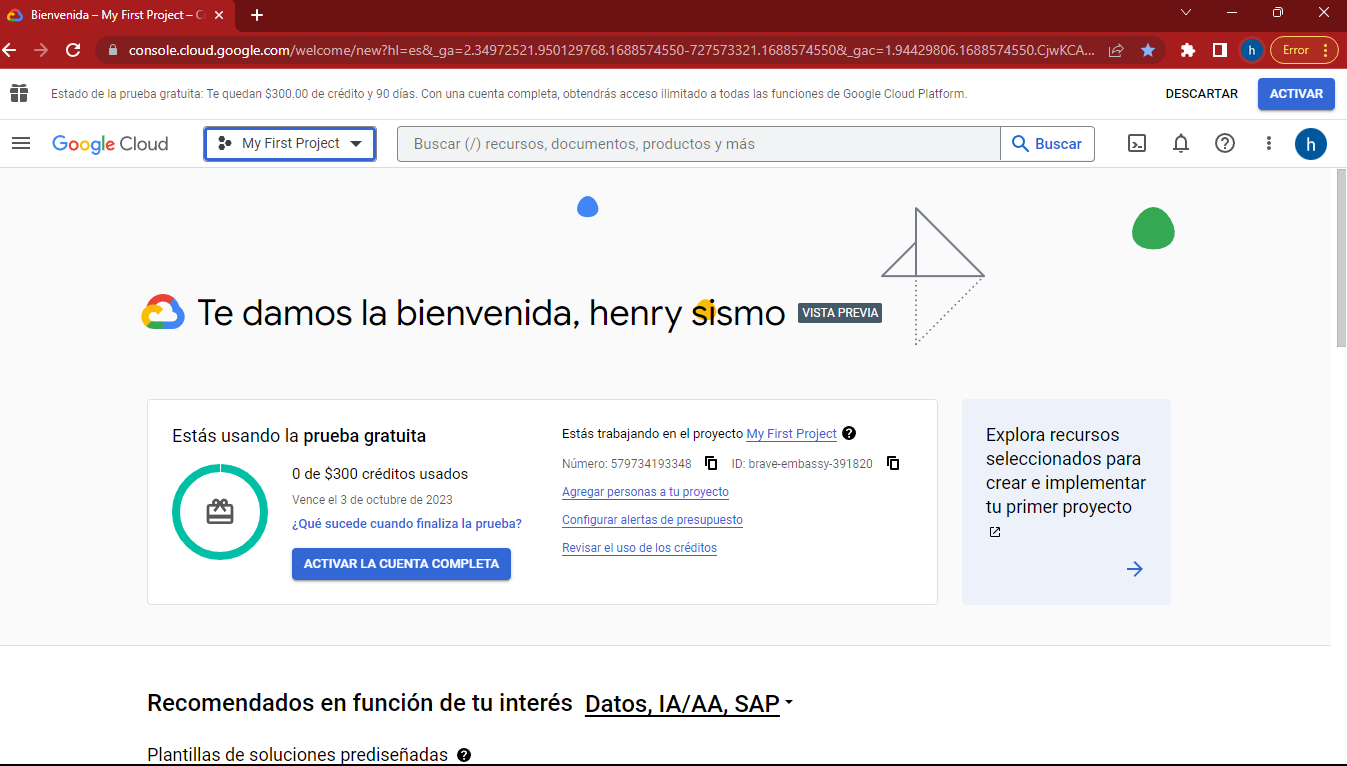

# Crear Nuevo Proyecto

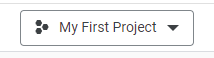

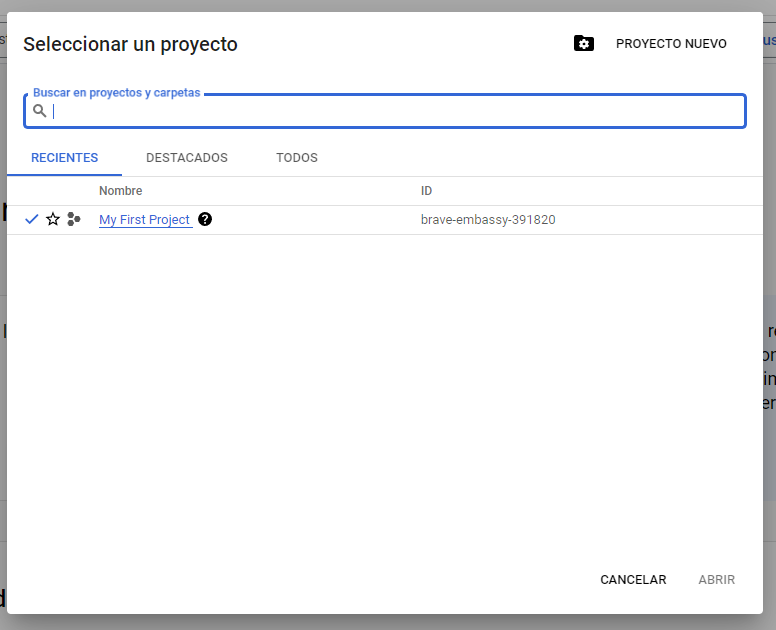

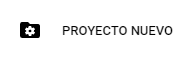

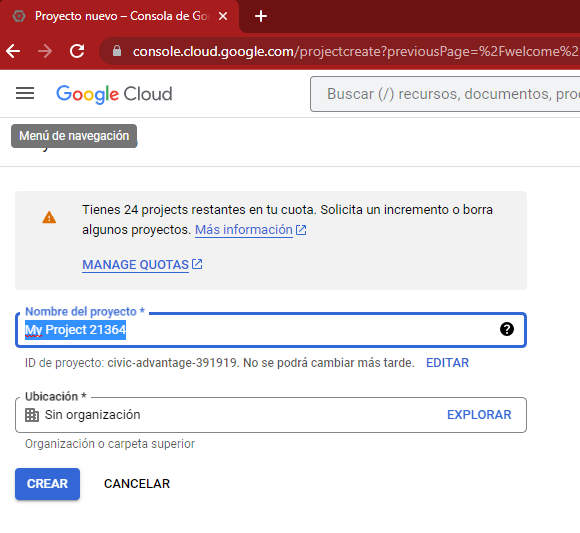

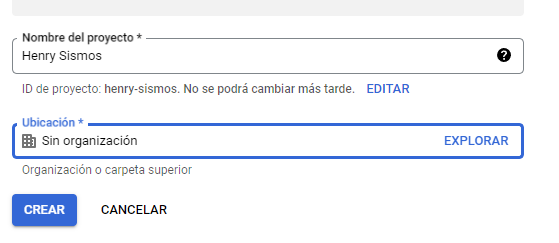

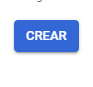

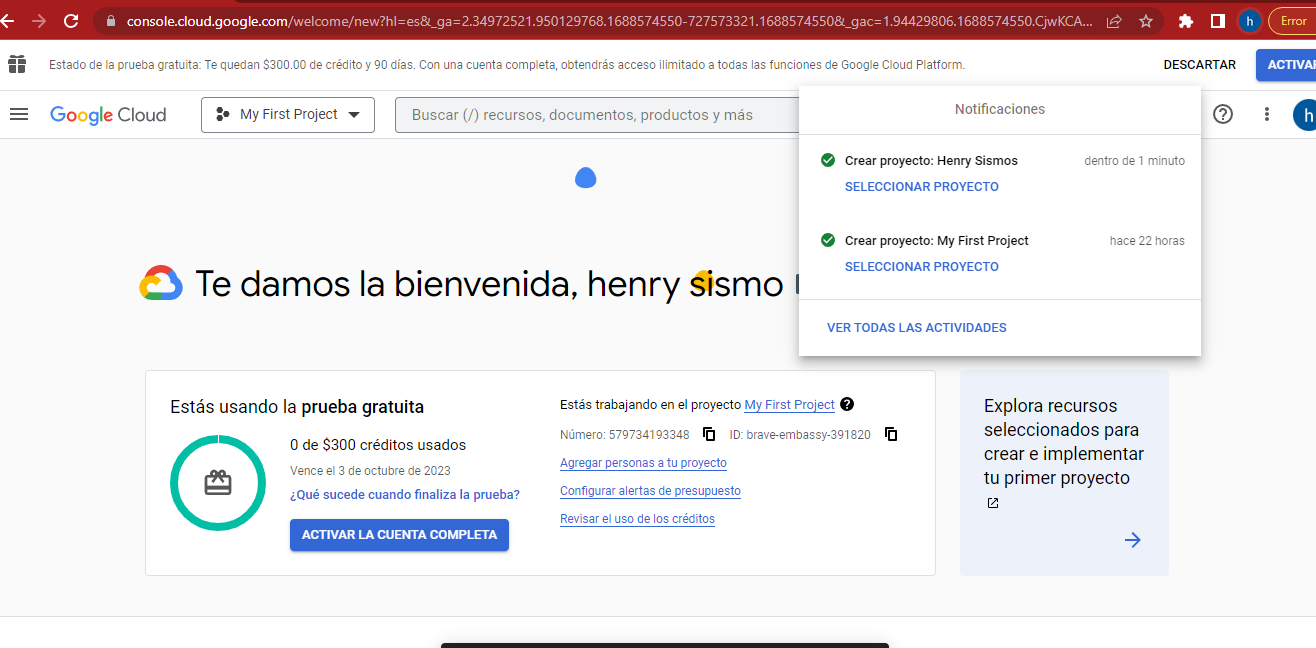

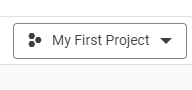

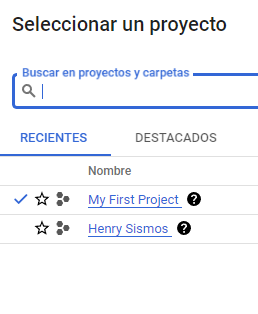

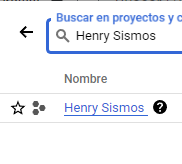

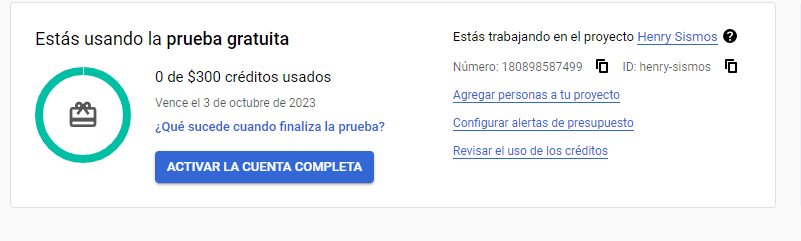

# Crear Credenciales para ejecutar código desde Python

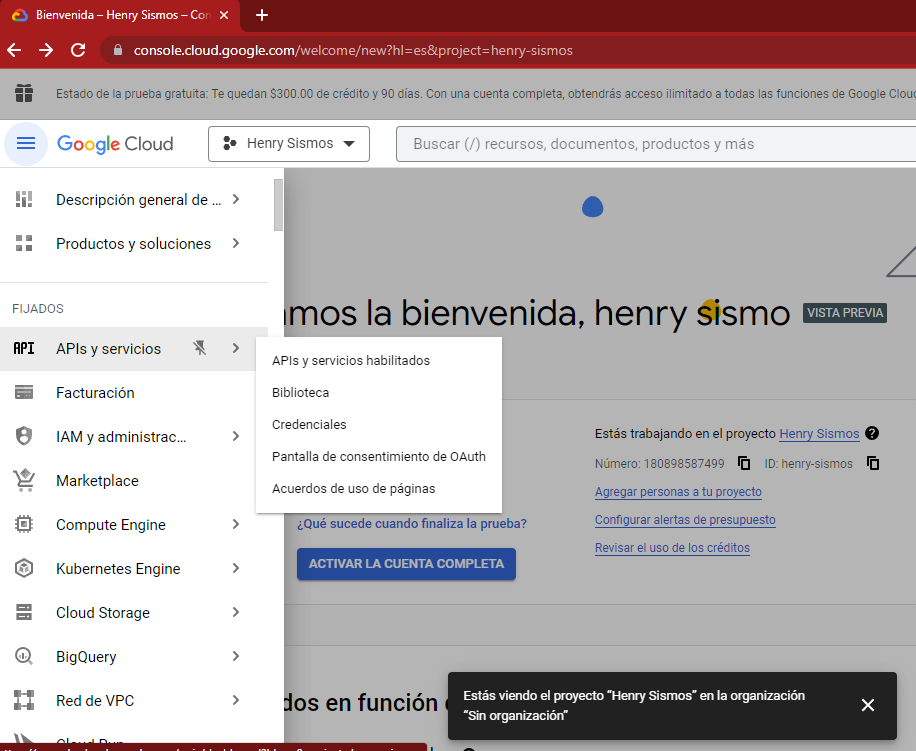


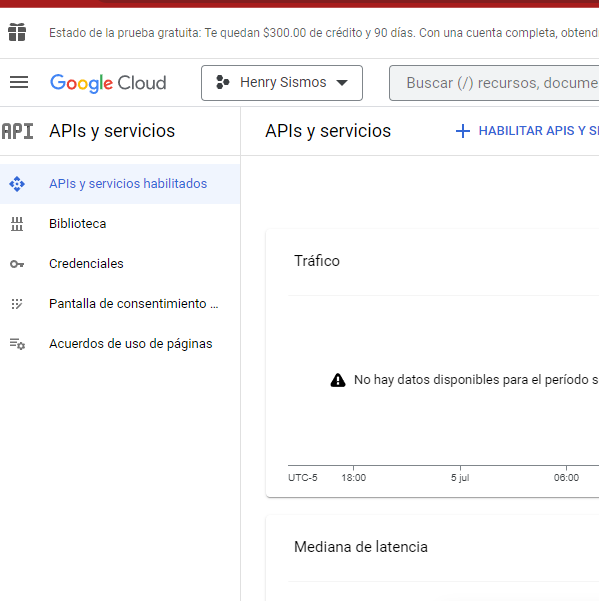 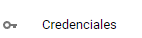

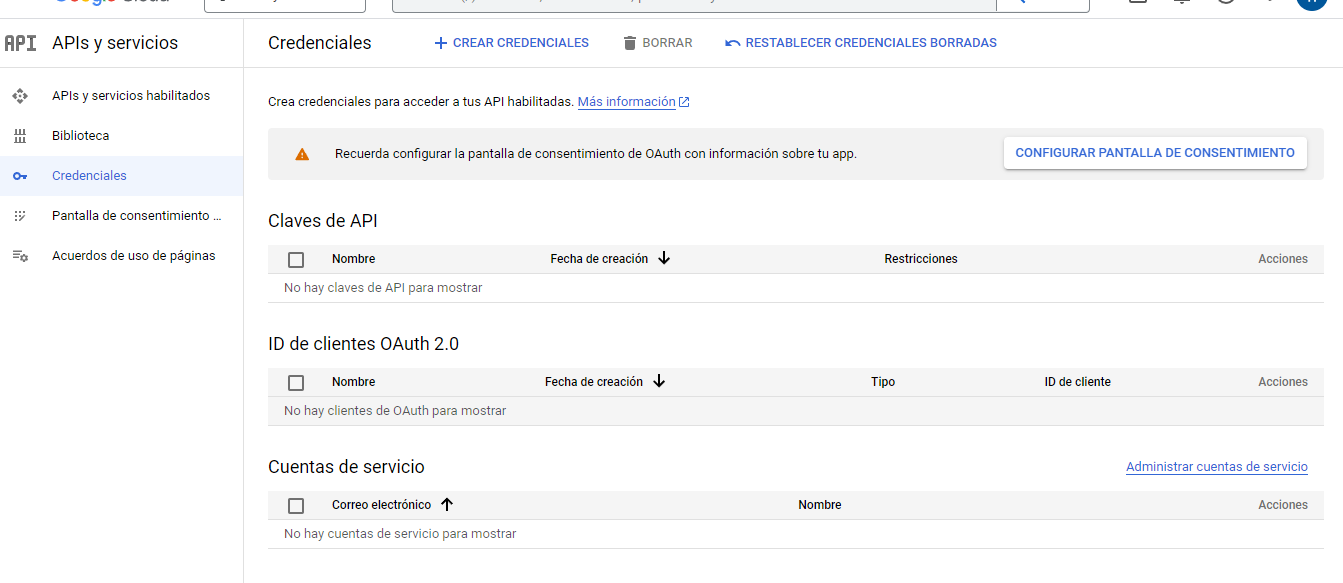 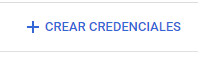 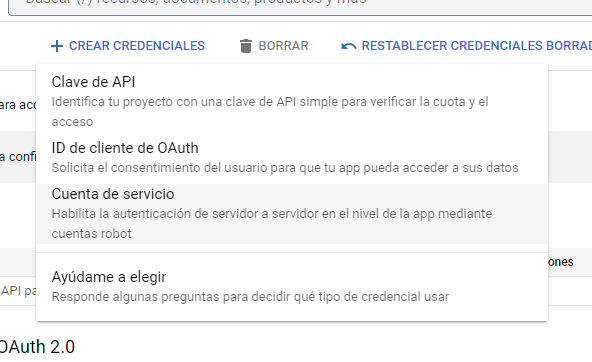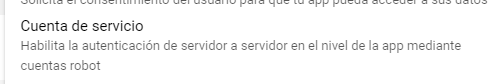

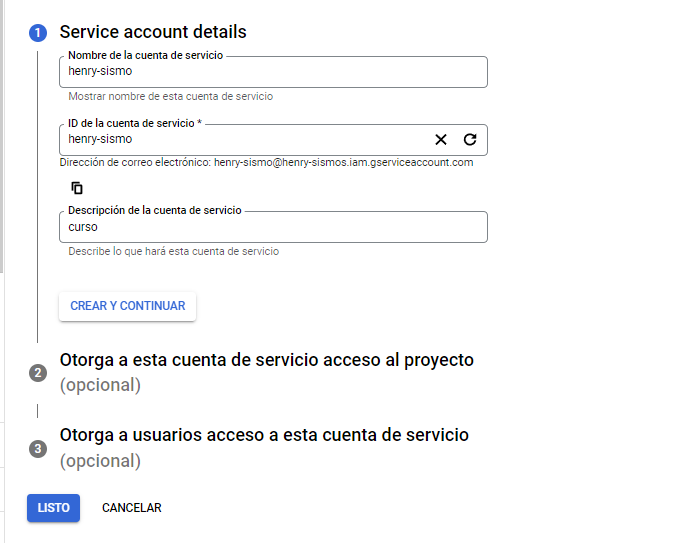

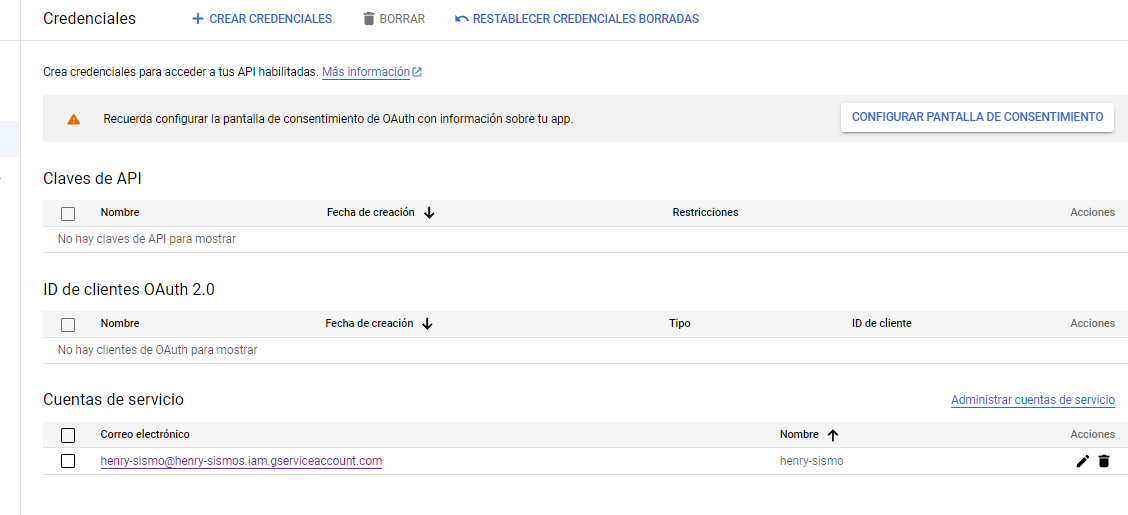 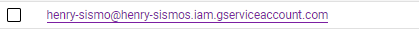

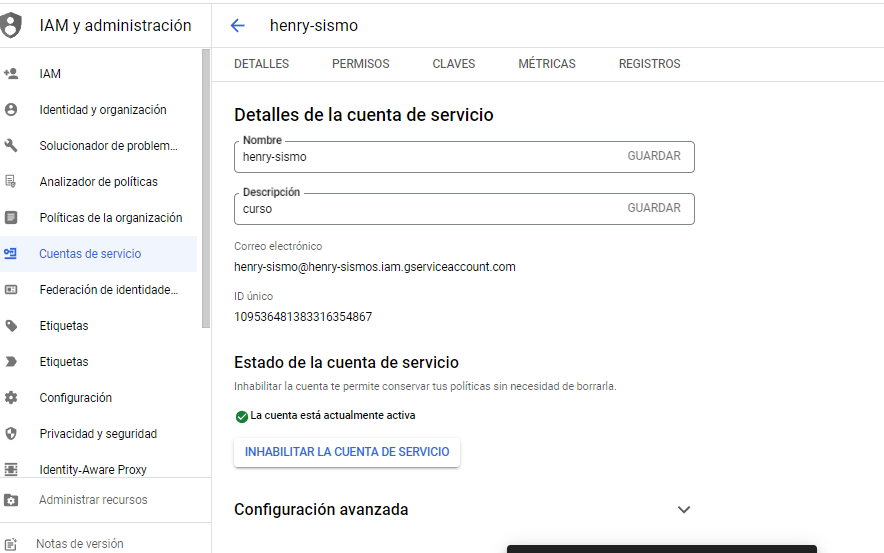![image-3.png]<br>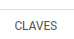

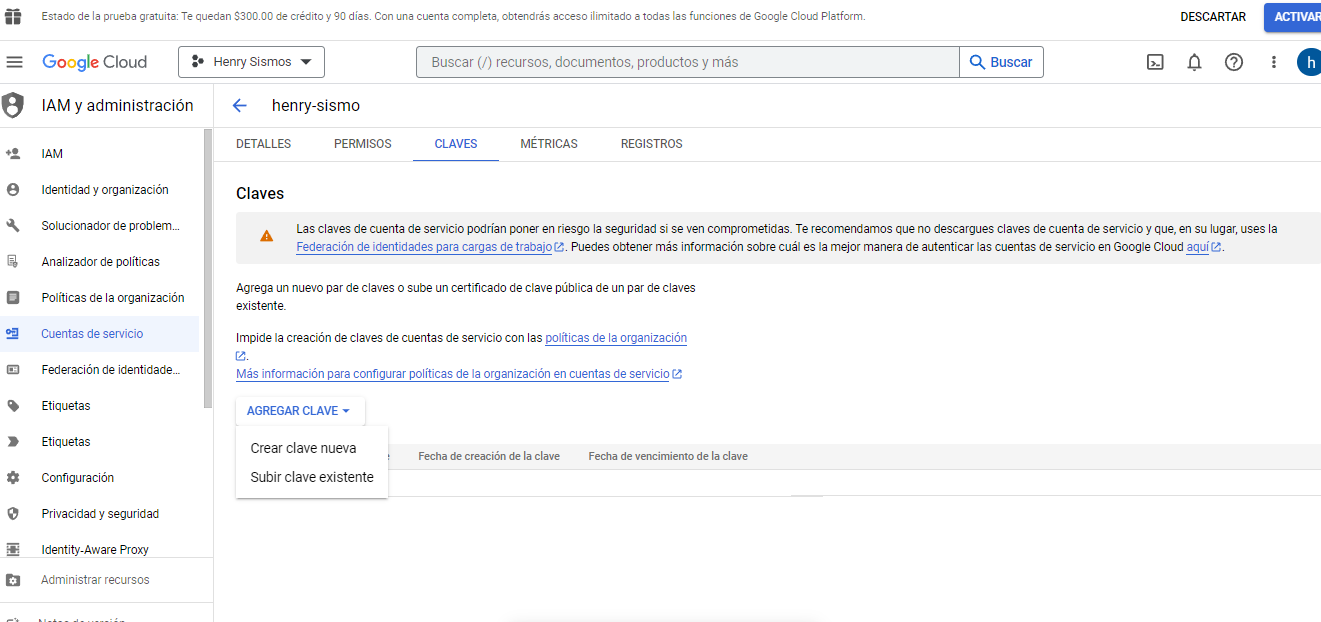

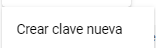

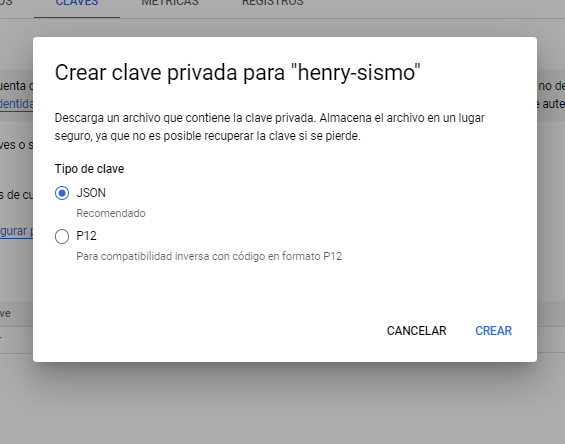
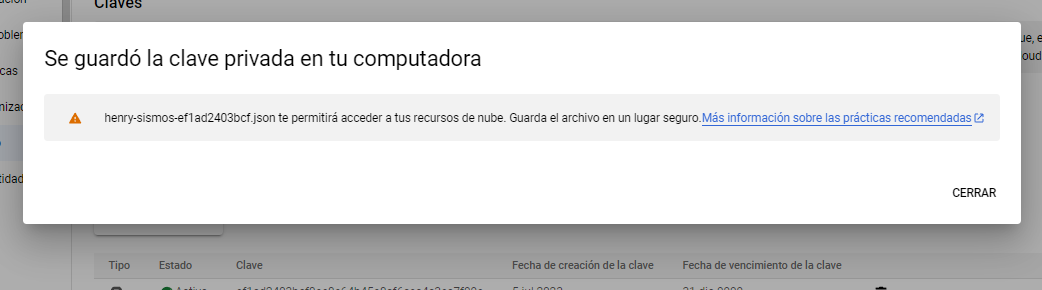

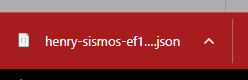

### La guardamos en la carpeta del proyecto
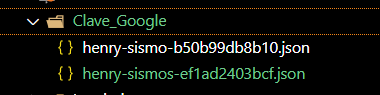
 para nuestro trabajo se llama henry_sismos-ef...

# Creamos un Data Set en google BgQuery

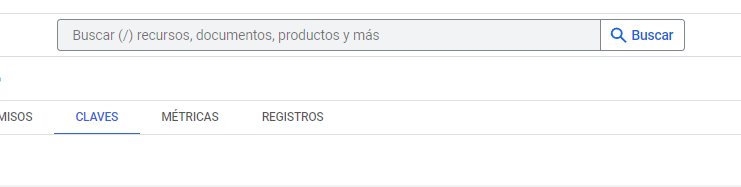<br>
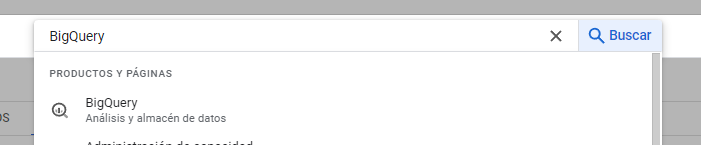

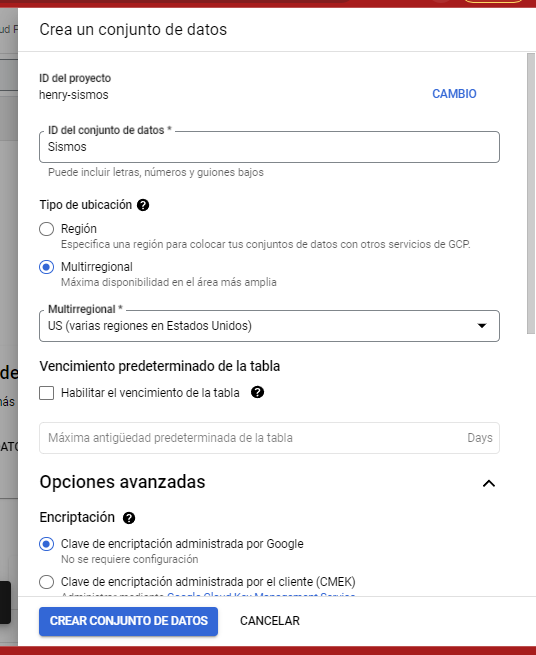

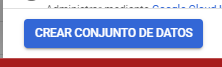

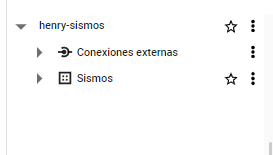

#### En el código de python se ejecuta con la librerías el activado de la llave

In [3]:
import requests
from google.cloud import bigquery
import pandas as pd
import datetime
from dateutil.parser import parse
import os
from datetime import datetime, timedelta
import reverse_geocoder as rg
from google.api_core.exceptions import Conflict
from google.cloud.exceptions import NotFound

# Creamos los permisos con la llave para ingresar a Google 
# activamos el servicio
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../notebooks/Clave_Google/henry-sismos-a343182ba163.json"

project_id = 'your-project-id'
client = bigquery.Client(project=project_id)

In [4]:
# Creamos una tabla con los datos de la api en google cloud desde vscode python

# Obtener los datos de la API de USGS
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
parameters = {
    'format': 'geojson',
    'starttime': '1990-01-01',
    'endtime': '2023-01-12',
    'minmagnitude': '2.5',
    'minlatitude': '-5.266',
    'maxlatitude': '15.708',
    'minlongitude': '276.328',
    'maxlongitude': '293.906',
    'limit': 20000
}
response = requests.get(url, params=parameters)
data = response.json()


# Configurar el proyecto, dataset y tabla
project_id = 'henry-sismos'
dataset_id = 'Sismos'
table_id = 'Colombia'

# Crear la tabla en BigQuery
client = bigquery.Client(project=project_id)
dataset_ref = client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)

schema = [
    bigquery.SchemaField('id', 'STRING'),
    bigquery.SchemaField('magnitude', 'FLOAT'),
    bigquery.SchemaField('place', 'STRING'),
    bigquery.SchemaField('time', 'TIMESTAMP'),
    bigquery.SchemaField('url', 'STRING')
    # Agrega más campos según los datos que desees almacenar
]

table = bigquery.Table(table_ref, schema=schema)
client.create_table(table)

# Insertar los datos en la tabla
rows = []
for feature in data['features']:
    properties = feature['properties']
    time_str = properties['time']
    time = pd.to_datetime(time_str, unit= "ms") #parse(time_str)
    row = (
        properties['ids'],
        properties['mag'],
        properties['place'],
        time,
        properties['url']
        # Ajusta los índices de las coordenadas si es necesario
    )
    rows.append(row)

client.insert_rows(table, rows)

[]

# Creamos un Pub/Sub

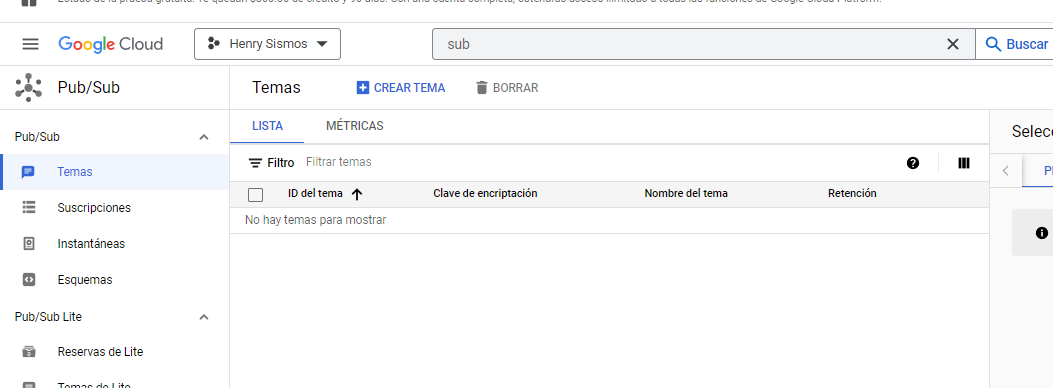

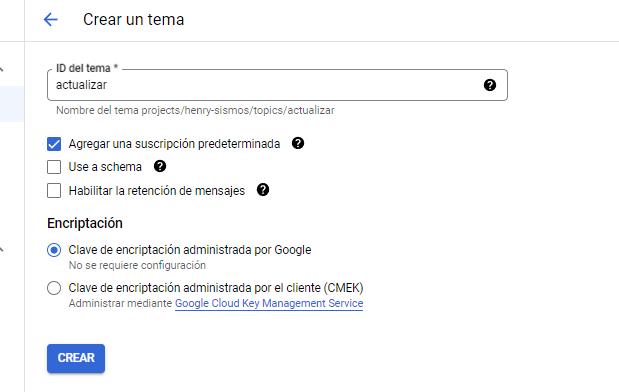

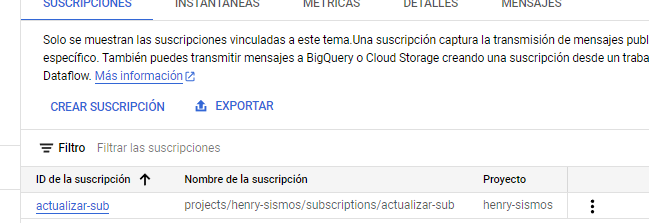

# Creamos un cloud scheduler o trabajo para programar la ejecución de una functions

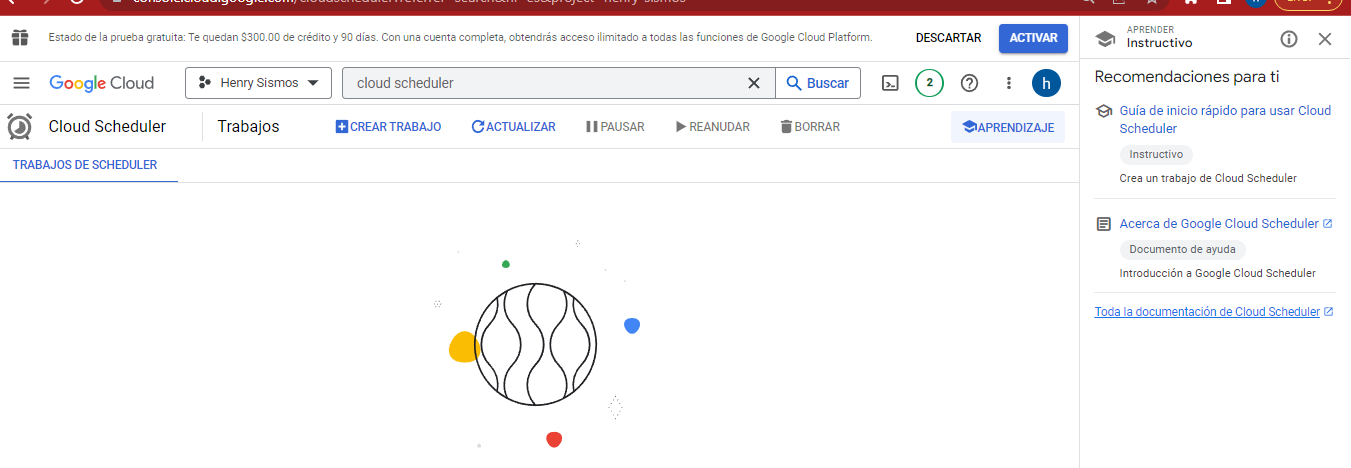

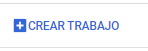

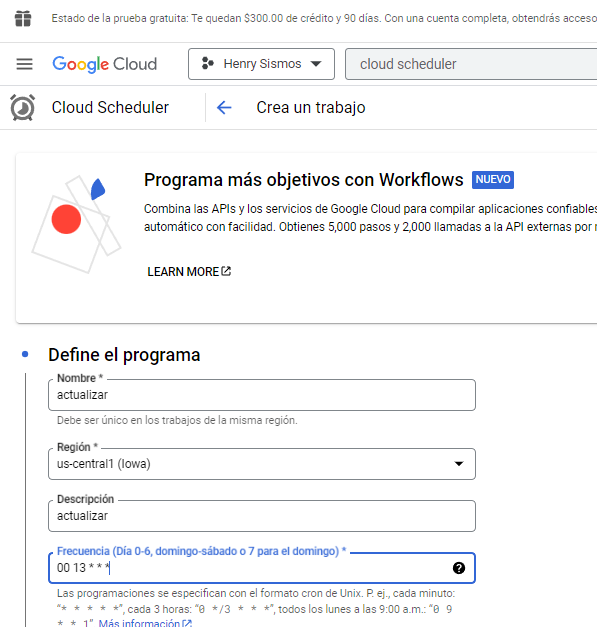

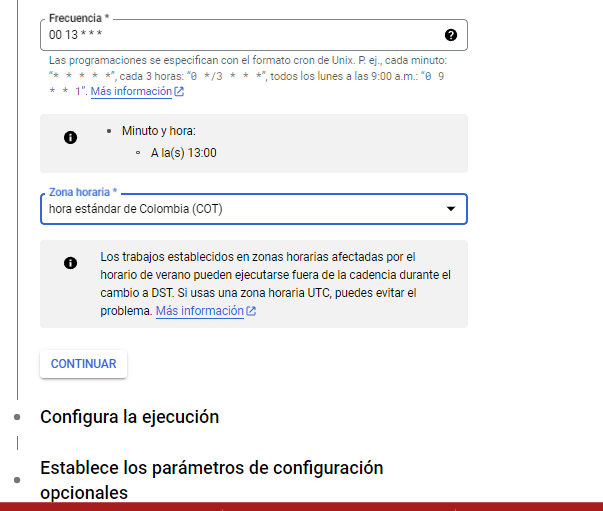

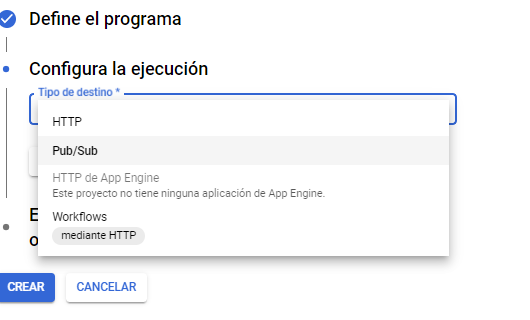

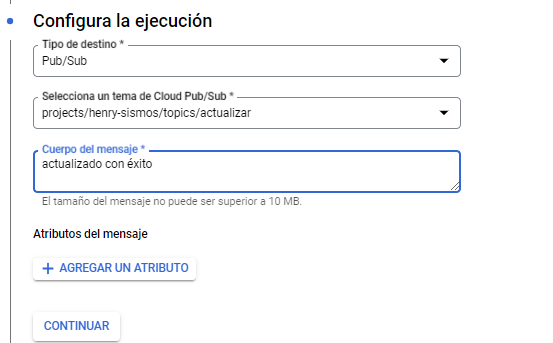

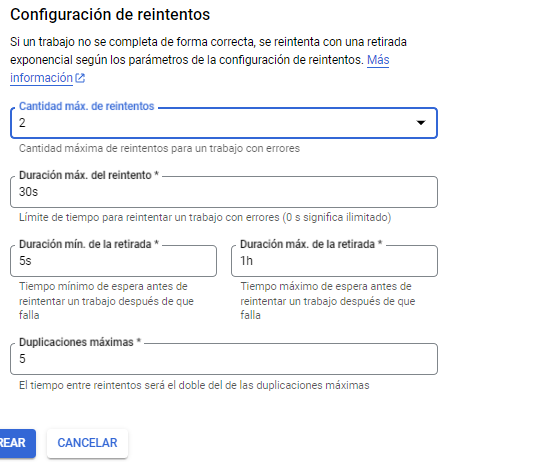

# Creamos la función en google functions, para actualizar la data

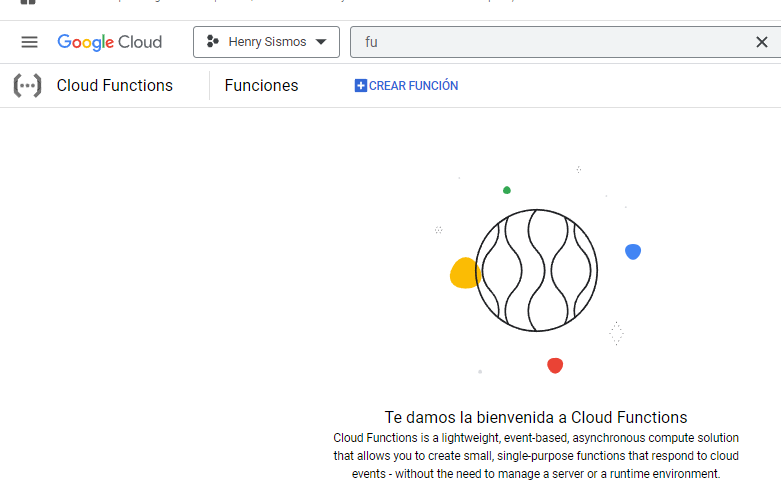

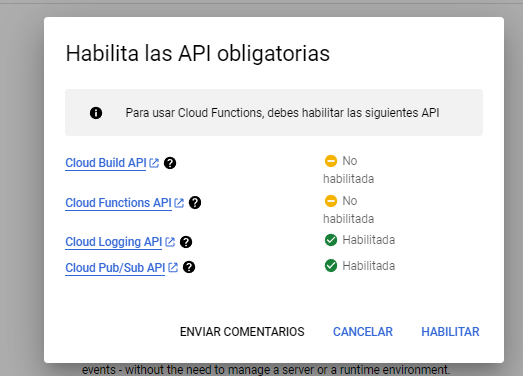

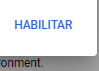

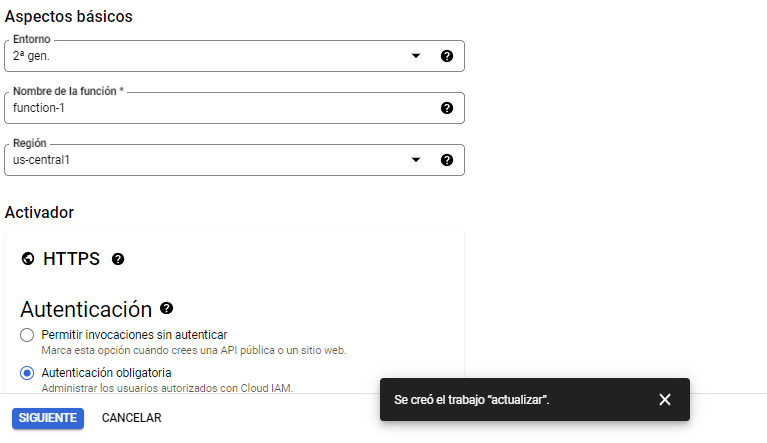

## IMPORTANTE - poe defecto en el entorno selecciona 2 gen, pero tiene que ser 1 gen

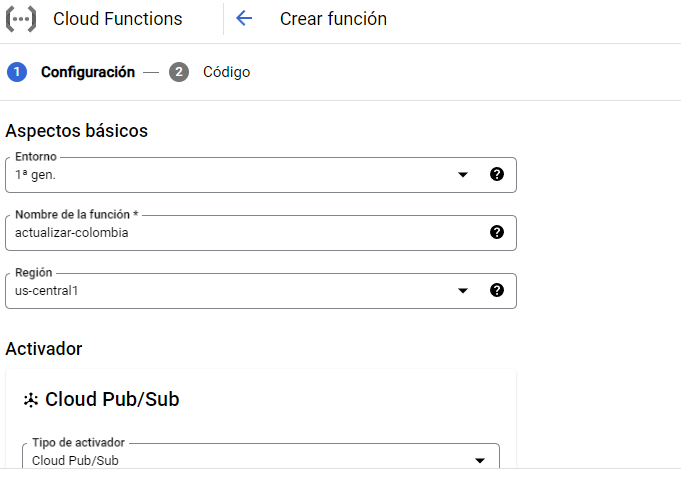

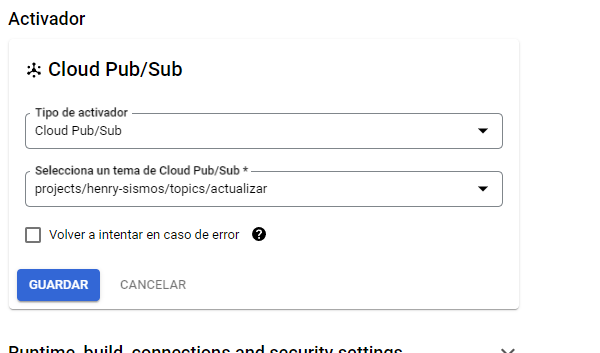

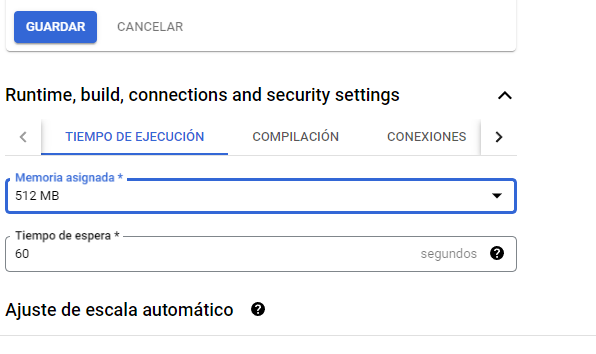

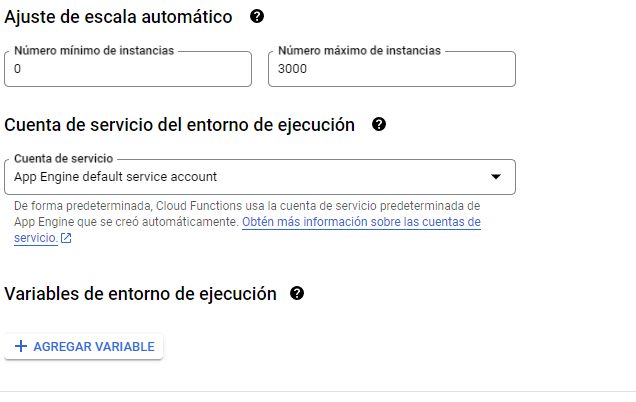

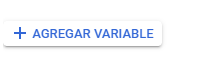

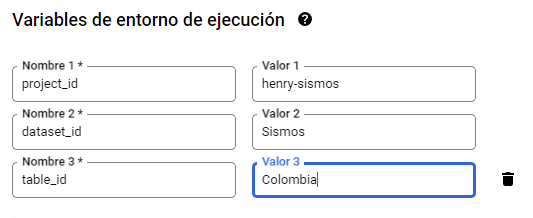

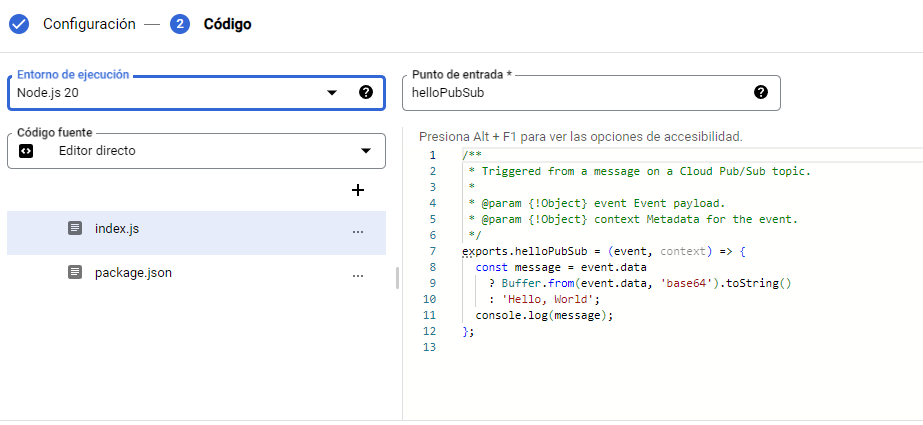

### Se crea el nuevo codigo ... Ojo el nombre de la funsion debe de ser igual al Punto de entrada

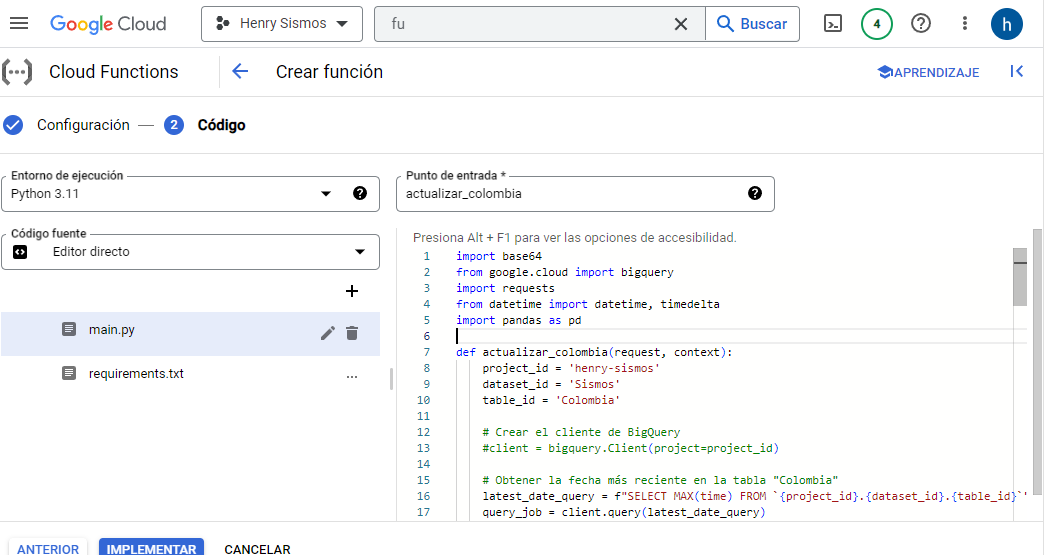

### requirements

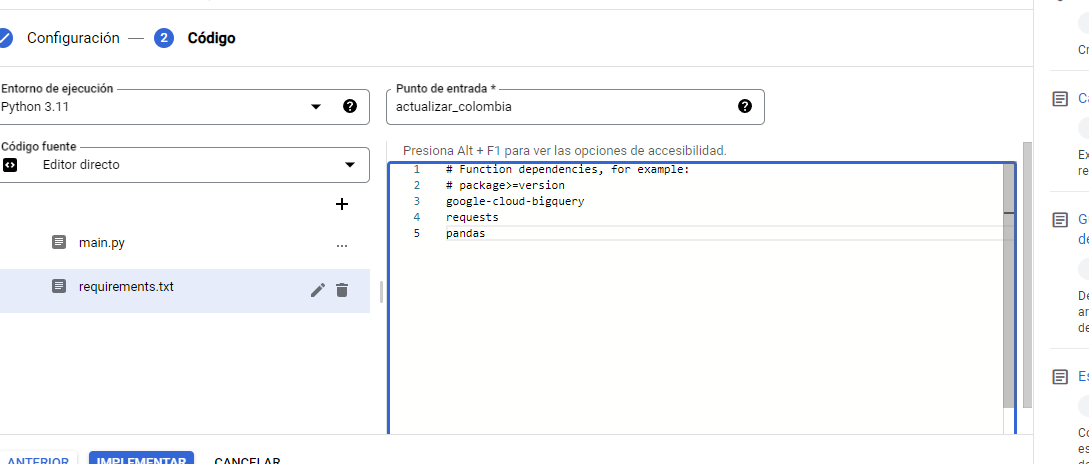<br>

ejecutamos => implementar y esperamos<br>
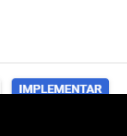

In [ ]:
# Codigo que se pega en google Function


import base64
from google.cloud import bigquery
import requests
from datetime import datetime, timedelta
import pandas as pd

def actualizar_colombia(request, context):
    project_id = 'henry-sismos'
    dataset_id = 'Sismos'
    table_id = 'Colombia'

    # Crear el cliente de BigQuery
    client = bigquery.Client(project=project_id)

    # Obtener la fecha más reciente en la tabla "Colombia"
    latest_date_query = f"SELECT MAX(time) FROM `{project_id}.{dataset_id}.{table_id}`"
    query_job = client.query(latest_date_query)
    latest_date_result = query_job.result()

    # Obtener el valor de la fecha más reciente
    for row in latest_date_result:
        latest_date = row[0]

    # Verificar si se obtuvo una fecha válida
    if latest_date is not None:
        latest_date = latest_date.date()
    else:
        # Si no hay fecha más reciente, establecer una fecha inicial
        latest_date = datetime(1990, 1, 1).date()

    # Obtener la fecha actual
    current_date = datetime.now().date()

    # Verificar si se necesita actualizar la tabla
    if current_date > latest_date:
        # Calcular la fecha de inicio y fin para la API
        start_date = latest_date + timedelta(days=1)
        end_date = current_date

        # Obtener los datos de la API de USGS
        url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'
        parameters = {
            'format': 'geojson',
            'starttime': start_date.strftime('%Y-%m-%d'),
            'endtime': end_date.strftime('%Y-%m-%d'),
            'minmagnitude': '2.5',
            'minlatitude': '-5.266',
            'maxlatitude': '15.708',
            'minlongitude': '276.328',
            'maxlongitude': '293.906',
            'limit': 20000
        }
        response = requests.get(url, params=parameters)
        data = response.json()

        # Insertar los datos en la tabla si hay nuevos datos
        if 'features' in data and len(data['features']) > 0:
            table_ref = client.dataset(dataset_id).table(table_id)
            table = client.get_table(table_ref)

            rows = []
            for feature in data['features']:
                properties = feature['properties']
                time_str = properties['time']
                time = pd.to_datetime(time_str, unit="ms")
                row = (
                    properties['ids'],
                    properties['mag'],
                    properties['place'],
                    time,
                    properties['url']
                )
                rows.append(row)

            client.insert_rows(table, rows)
        else:
            "No hay nuevos datos para insertar."
    else:
        "La tabla ya está actualizada."

# Todo listo
Probamos la función

### Antes
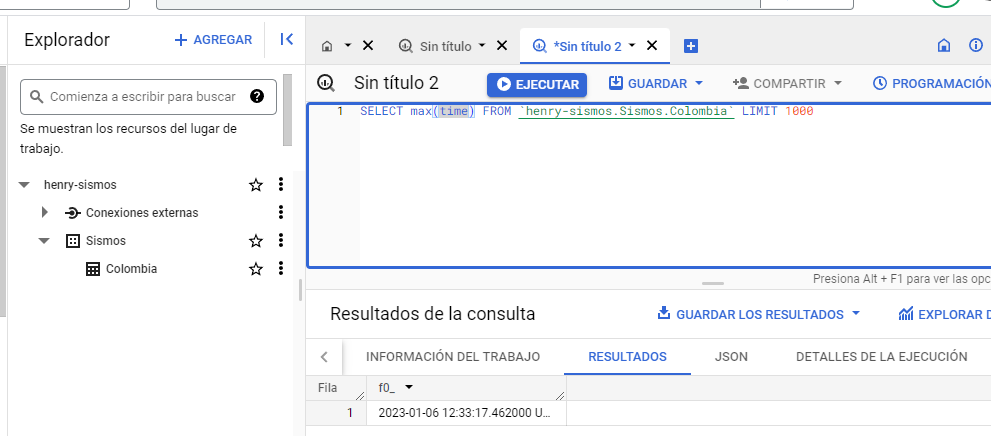

## Después
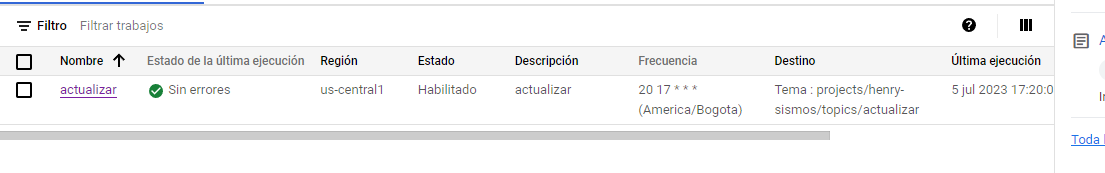

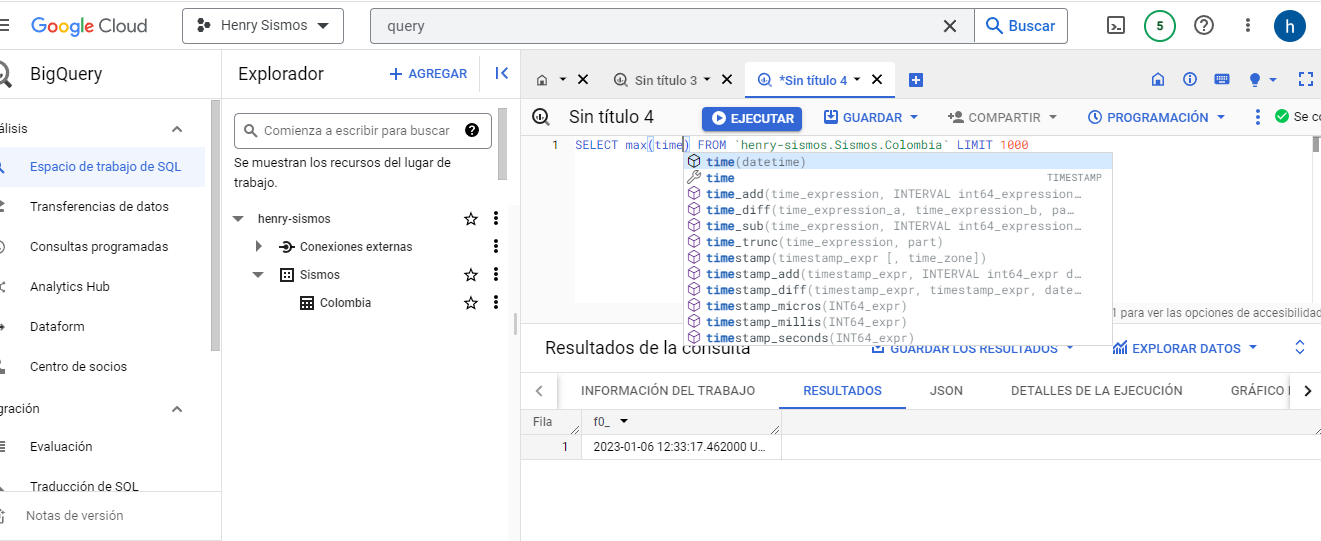